In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torchvision import  datasets

train_data = datasets.FashionMNIST(root="data",
                                   train = True,
                                    download=True,
                                   transform=ToTensor(),
                                   target_transform = None)

test_data = datasets.FashionMNIST(root="data",
                                  train = False,
                                  download=False,
                                  transform=ToTensor(),
                                  target_transform=None)



100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.6MB/s]


In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
classes = train_data.classes

In [6]:
image, label = train_data[0]


image.shape, label

(torch.Size([1, 28, 28]), 9)

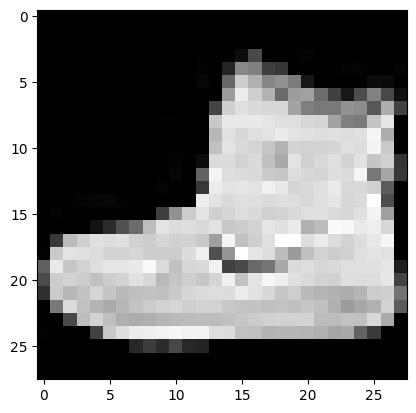

In [7]:
import matplotlib.pyplot as plt


plt.imshow(image.squeeze(),cmap='gray')

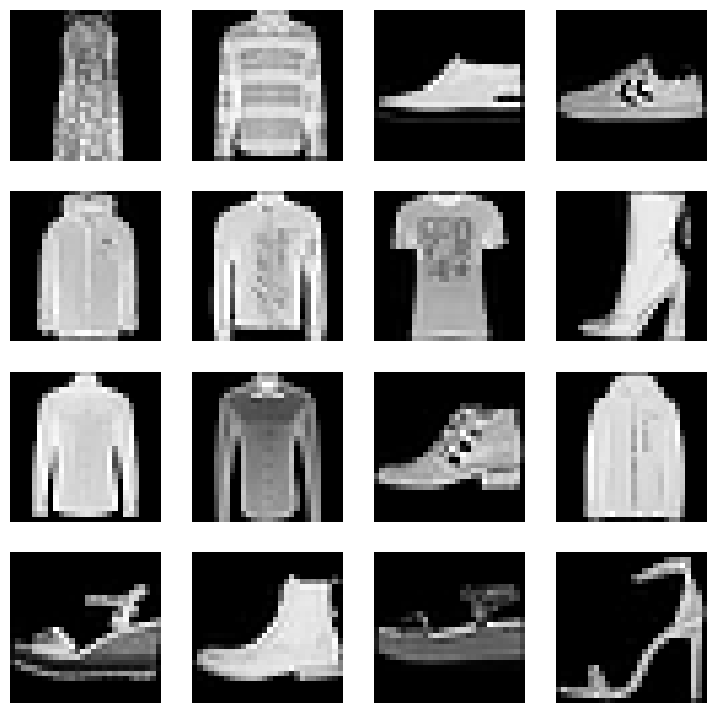

In [8]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size =[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.axis(False)
    plt.imshow(img.squeeze(), cmap='gray')

In [9]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ac992a8c650>,
 <torch.utils.data.dataloader.DataLoader at 0x7ac992c63210>)

In [11]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [12]:
train_features_batch, train_label_batch= next(iter(train_dataloader))

In [13]:
train_features_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Create a flatten layer

In [14]:
flatten = nn.Flatten()

x = train_features_batch[0]

output = flatten(x)

In [15]:
class FashionModel(nn.Module):
  def __init__(self, input_shape:int, hidden:int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden),
        nn.Linear(in_features=hidden, out_features=output_shape))

  def forward(self, x):
    return self.layer_stack(x)


In [16]:
torch.manual_seed(42)

model = FashionModel(input_shape=784, hidden=10, output_shape=len(classes))
model.to("cpu")

FashionModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
## set loss function and optimizer


loss_fn = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [18]:
import requests
from pathlib import Path

# Download helper function from learn pytorch repo
if Path("helper_function.py").is_file():
    print("files is there")
else:
    print("download the fils")

request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
with open("helper_function.py", "wb") as f:
    f.write(request.content)

download the fils


In [19]:
from helper_function import accuracy_fn

## create a function to time our experiment

In [20]:
from timeit import default_timer as timer

def print_train_time(start:float, end:float, device:torch.device=None):

  total_time = end - start
  print(f"Train time of {device} : {total_time:.3f} seconds...")
  return total_time

In [21]:
start_time = timer()

# some code...

end_time = timer()

print_train_time(start=start_time, end=end_time, device="cpu")

Train time of cpu : 0.000 seconds...


4.182400000729558e-05

In [22]:
from tqdm.auto import tqdm

torch.manual_seed(42)

train_time_start = timer() # ----> timer start

epochs = 3

# create train and test loop

for epoch in tqdm(range(epochs)):
  print(f"epoch : {epochs}\n__....")

  # train loss

  train_loss = 0
  # add a loop to through the training batchs

  for batch, (x, y) in enumerate(train_dataloader):

    model.train()

    y_pred = model(x)

    # calculate the loss function
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # optimizer zero_grad
    optimizer.zero_grad()

    # backward loss
    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(x)} / {len(train_dataloader.dataset)} sample...")
  # evalute the total by  lenght of train-dataloader
  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in test_dataloader:
      # forward pass
      test_pred = model(x)
      test_loss += loss_fn(test_pred, y)

      # calculate the loss
      test_acc += accuracy_fn(y_true = y, y_pred=y_pred.argmax(dim=1))

    test_loss /= len(test_data)
    test_acc /= len(test_dataloader)

  print(f"\ntrain loss : {train_loss:.4f} | test_loss : {test_loss:.4f} | test_acc : {test_acc:.4f}")

  # calculate the training time

train_time_end_on_cpu = timer()
total_train_time_model = print_train_time(start=train_time_start,
                                         end=train_time_end_on_cpu,
                                         device=str(next(model.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 3
__....
Looked at 0 / 60000 sample...
Looked at 12800 / 60000 sample...
Looked at 25600 / 60000 sample...
Looked at 38400 / 60000 sample...
Looked at 51200 / 60000 sample...

train loss : 0.5904 | test_loss : 0.0065 | test_acc : 87.5000
epoch : 3
__....
Looked at 0 / 60000 sample...
Looked at 12800 / 60000 sample...
Looked at 25600 / 60000 sample...
Looked at 38400 / 60000 sample...
Looked at 51200 / 60000 sample...

train loss : 0.4763 | test_loss : 0.0117 | test_acc : 78.1250
epoch : 3
__....
Looked at 0 / 60000 sample...
Looked at 12800 / 60000 sample...
Looked at 25600 / 60000 sample...
Looked at 38400 / 60000 sample...
Looked at 51200 / 60000 sample...

train loss : 0.4550 | test_loss : 0.0054 | test_acc : 87.5000
Train time of cpu : 23.272 seconds...


Train time of cpu : 29.798 seconds...


## Make Predictions and get model result

In [54]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn):

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x, y in tqdm(data_loader):
      # make predictions
      y_pred = model(x)

      # accumulate the loss function and acc function per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))

      # scale loss and acc to find the average loss/acc per batch

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__,# only works when model was created with a class
            "model_loss" : loss.item(),
            "mode_acc" : acc}

# calculate model result on test datasets

model_result = eval_model(model,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn)

model_result


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModel',
 'model_loss': 0.47663894295692444,
 'mode_acc': 83.42651757188499}

## setup device agnotic-code (for using a GPU if there is one)

In [24]:
!nvidia-smi

Fri Jun 13 07:47:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
class fashionmodel(nn.Module):
  def __init__(self,input_shape: int, output_shape: int, hidden : int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden),
        nn.ReLU(),
        nn.Linear(in_features=hidden, out_features=output_shape),
        nn.ReLU())

  def forward(self,x:torch.Tensor):
    return self.layer_stack(x)

In [27]:
torch.manual_seed(42)

model_1 = fashionmodel(input_shape=784, output_shape=len(classes), hidden=10)
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## Setup loss function and optimizer

In [28]:
from helper_function import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### Function training and evalution/testing loops

  1.train loop - `train step()`

   2.test loop - `test step()`

In [29]:
def train_model(model: torch.nn.Module,
                data_loader : torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn,
                device : torch.device=device):

  ''' perform a training loop with model trying to learn on data loader'''
  train_loss, train_acc = 0, 0

  # Put the model into train mode
  model.train()

  for batch, (x, y) in enumerate(data_loader):
    #put the x, y into device
    x = x.to(device)
    y=y.to(device)

    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | train acc: {train_acc:.2f}%")

In [30]:
def test_model(model:torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device : torch.device = device):

  test_loss ,test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x, y in data_loader:

      x = x.to(device)
      y = y.to(device)

      test_pred = model(x)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Adjusting metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}% \n")


In [31]:
torch.manual_seed(42)

from timeit import default_timer as timer


train_time_start_on_gpu = timer()

# set epochs

epochs = 3

# create a optimization and evalution loop using train_step() and test_step()


for epoch in tqdm(range(epochs)):
  print(f"Epochs : {epoch}\n_________...")
  train_model(model=model_1,
              data_loader= train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
  test_model(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_on_gpu = timer()


total_train_time_model = print_train_time(start=train_time_start_on_gpu, end=train_time_end_on_gpu, device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 0
_________...
Train loss : 1.09199 | train acc: 61.34%
Test loss : 0.95636 | Test acc : 65.00% 

Epochs : 1
_________...
Train loss : 0.78101 | train acc: 71.93%
Test loss : 0.72227 | Test acc : 73.91% 

Epochs : 2
_________...
Train loss : 0.67027 | train acc: 75.94%
Test loss : 0.68500 | Test acc : 75.02% 

Train time of cuda : 27.104 seconds...


Train time of cuda : 26.711 seconds...

In [32]:
model_result

{'model_name': 'FashionModel',
 'model_loss': 0.0010611428879201412,
 'mode_acc': 0.30028917735831345}

In [55]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device : torch.device=device):

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x, y in tqdm(data_loader):
      x, y = x.to(device),y.to(device)
      # make predictions
      y_pred = model(x)

      # accumulate the loss function and acc function per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred = y_pred.argmax(dim=1))

      # scale loss and acc to find the average loss/acc per batch

    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name" : model.__class__.__name__,# only works when model was created with a class
            "model_loss" : loss.item(),
            "mode_acc" : acc}

In [56]:
model1_result = eval_model(model=model_1,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=device)
model1_result


  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'fashionmodel',
 'model_loss': 0.6850008964538574,
 'mode_acc': 75.01996805111821}

In [57]:
model_result

{'model_name': 'FashionModel',
 'model_loss': 0.47663894295692444,
 'mode_acc': 83.42651757188499}